In [1]:
import requests
import re
import time
import pandas as pd 
import spacy
from bs4 import BeautifulSoup

import matplotlib.pyplot as plt


nlp = spacy.load('en_core_web_sm', disable=['parser', 'lemmatizer', 'tagger'])


In [229]:
def clean_entities(ls):
    ls = [word.lower() for word in ls]
    ls = [re.sub(r'^the ', '', word) for word in ls]
    return ls

In [225]:
def count_words(clean_data):
    ngrams_dict = {}
    for ngram in clean_data:
        if ngram in ngrams_dict:
            ngrams_dict[ngram] += 1
        else:
            ngrams_dict[ngram] = 1
    return ngrams_dict

In [248]:
def barplot_entities(df, filter, source):
    a = df[df['entity_label'] == filter]
    b = a['entity_text'].tolist()
    b = clean_entities(b)
    c = count_words(b)
    v = pd.DataFrame(
    {'word': c.keys(), 'count': c.values() } )
    
    v = v[:25].copy()

    v.sort_values(by = ['count'], inplace = True, ascending = True)

    plt.barh(v['word'], v['count'])
    plt.ylabel('Usage')
    plt.title('Top ' + filter + 's Mentioned in ' + source + ' News Articles about Covid-19' )

    plt.rcParams["figure.figsize"] = [16,9]

    plt.show()

In [ ]:
#PERSON:      People, including fictional.
#NORP:        Nationalities or religious or political groups.
#FAC:         Buildings, airports, highways, bridges, etc.
#ORG:         Companies, agencies, institutions, etc.
#GPE:         Countries, cities, states.
#LOC:         Non-GPE locations, mountain ranges, bodies of water.
#PRODUCT:     Objects, vehicles, foods, etc. (Not services.)
#EVENT:       Named hurricanes, battles, wars, sports events, etc.
#WORK_OF_ART: Titles of books, songs, etc.
#LAW:         Named documents made into laws.
#LANGUAGE:    Any named language.
#DATE:        Absolute or relative dates or periods.
#TIME:        Times smaller than a day.
#PERCENT:     Percentage, including ”%“.
#MONEY:       Monetary values, including unit.
#QUANTITY:    Measurements, as of weight or distance.
#ORDINAL:     “first”, “second”, etc.
#CARDINAL:    Numerals that do not fall under another type.

In [ ]:
keyword = re.compile(r'covid|coronavirus|vaccine|omicron|delta', re.IGNORECASE)
vaccines = re.compile(r'pfizer|moderna', re.IGNORECASE)

In [230]:
url = 'https://www.npr.org/sections/news/'
source = 'NPR'

#url = 'https://www.foxnews.com/'
#source = 'FOX'

# I could iterate through a list of lists or list of tuples 

response = requests.get(url)
initial_page = BeautifulSoup(response.text, 'html.parser')

scraped_pages = {}

#article_id = 0
out = {}

for link in initial_page.findAll('a'):
    try:
        page_url = link['href']
        if keyword.search(page_url):
            if not page_url in scraped_pages.keys():
                #article_id = article_id + 1
                # keep track of scraped pages 
                scraped_pages[page_url] = source

                next_page = requests.get(page_url)
                article_content = BeautifulSoup(next_page.text, 'html.parser')

                #paragraph_id = 0
                for paragraph in article_content.findAll('p'):
                    paragraph = list(paragraph.stripped_strings)
                    
                    # each sentence is a list
                    for sentence in paragraph: 
                        sentence = nlp(sentence)

                        for entity in sentence.ents:
                            if not entity.label_ in out.keys():
                                out[entity.label_] = [entity.text]
                            else:
                                out[entity.label_].append(entity.text)

                            
                    # if I want to make a DF instead:
                    #paragraph_id = paragraph_id + 1
                    #out[str(article_id) + '~' + str(paragraph_id) + '~' + str(page_url) ] = list(paragraph.stripped_strings)
                
                time.sleep(1)
   
    except:
        pass


In [231]:
citations = pd.DataFrame(
    {'url': scraped_pages.keys(), 'source': scraped_pages.values()} )

citations.to_csv('/home/stephbuon/projects/test/named_entities_' + source + '.csv')

named_entites = pd.DataFrame(
    {'entity_label': out.keys(), 'entity_text':out.values() } )
named_entites = named_entites.explode('entity_text')

for index, row in named_entites.iterrows():
    row['entity_label'] = 'EVENT' if (re.match(keyword, row['entity_text'])) else row['entity_label']
    row['entity_label'] = 'ORG' if (re.match(vaccines, row['entity_text'])) else row['entity_label']

named_entites.to_csv('/home/stephbuon/projects/test/named_entities_' + source + '.csv')

In [232]:
fox_ne = pd.read_csv('/home/stephbuon/projects/test/named_entities_FOX.csv')
npr_ne = pd.read_csv('/home/stephbuon/projects/test/named_entities_NPR.csv')

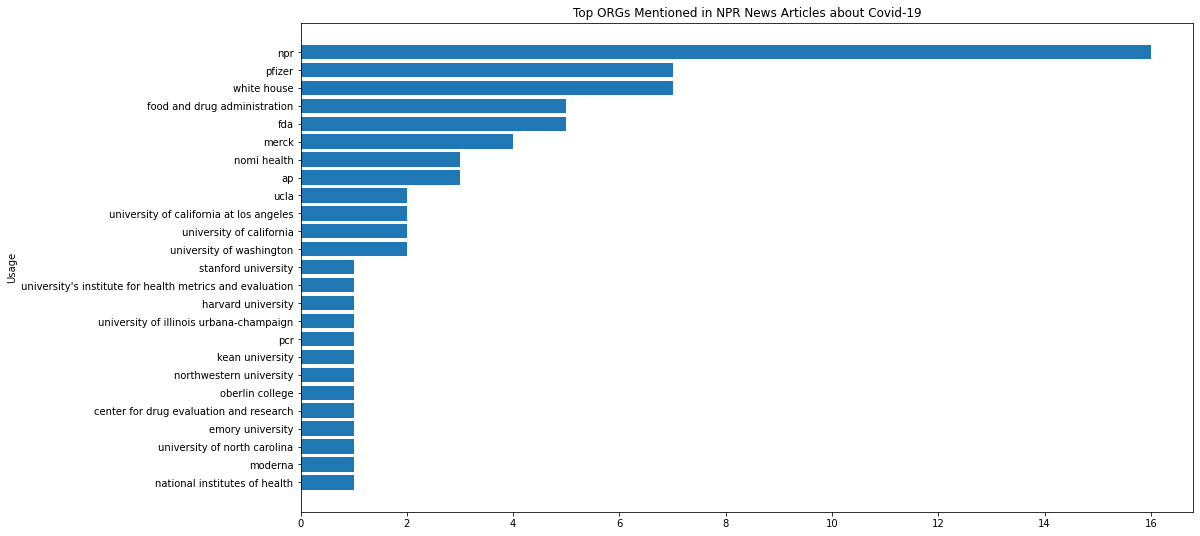

In [249]:
barplot_entities(npr_ne, 'ORG', source) # cut off the 's 

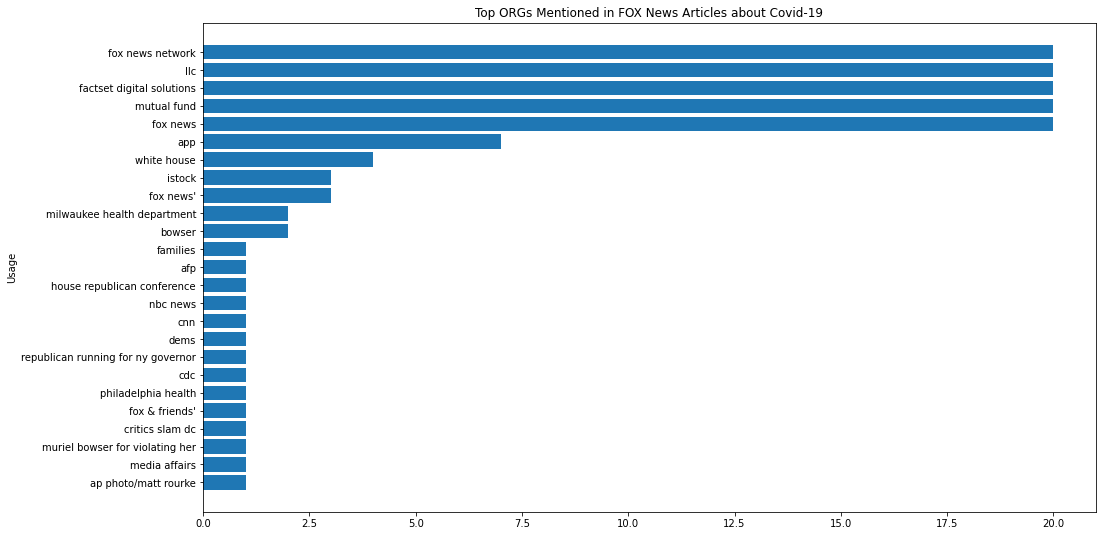

In [251]:
barplot_entities(fox_ne, 'ORG', 'FOX')